<a href="https://colab.research.google.com/github/vaishnavkk/FineTuning/blob/main/SVM-using-optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd #read file
import numpy as np #matrix multiplication
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set()

df= pd.read_csv('/oasis_longitudinal.csv')
df.head()


,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Load the data
df = pd.read_csv('/oasis_longitudinal.csv')

# Preprocess the data
df = df.dropna()
X = df.drop(['Subject ID', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'M/F', 'Hand', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR'], axis=1)


In [16]:
# Check missing values by each column
pd.isnull(df).sum()
# The column, SES has 8 missing values

Subject ID    0
MRI ID        0
Group         0
Visit         0
MR Delay      0
M/F           0
Hand          0
Age           0
EDUC          0
SES           0
MMSE          0
CDR           0
eTIV          0
nWBV          0
ASF           0
dtype: int64

In [17]:
# Dropped the 8 rows with missing values in the column, SES
df_dropna = df.dropna(axis=0, how='any')
pd.isnull(df_dropna).sum()

Subject ID    0
MRI ID        0
Group         0
Visit         0
MR Delay      0
M/F           0
Hand          0
Age           0
EDUC          0
SES           0
MMSE          0
CDR           0
eTIV          0
nWBV          0
ASF           0
dtype: int64

In [18]:
df_dropna['Group'].value_counts()

Nondemented    190
Demented       127
Converted       37
Name: Group, dtype: int64

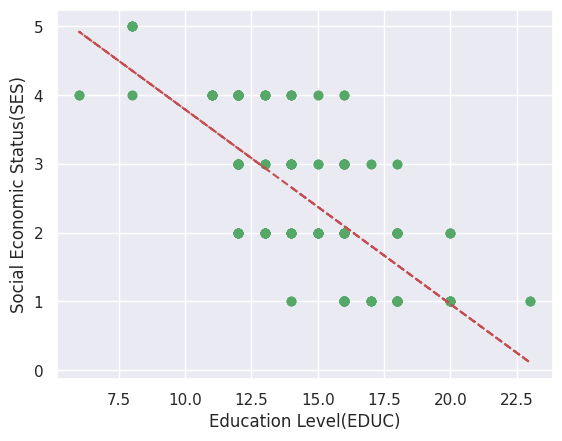

In [19]:
# Draw scatter plot between EDUC and SES
x = df['EDUC']
y = df['SES']

ses_not_null_index = y[~y.isnull()].index
x = x[ses_not_null_index]
y = y[ses_not_null_index]

# Draw trend line in red
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, y, 'go', x, p(x), "r--")
plt.xlabel('Education Level(EDUC)')
plt.ylabel('Social Economic Status(SES)')

plt.show()

In [20]:
df.groupby(['EDUC'])['SES'].median()

EDUC
6     4.0
8     5.0
11    4.0
12    3.0
13    2.0
14    3.0
15    2.0
16    2.0
17    1.0
18    2.0
20    1.0
23    1.0
Name: SES, dtype: float64

In [21]:
df["SES"].fillna(df.groupby("EDUC")["SES"].transform("median"), inplace=True)

In [22]:
# I confirm there're no more missing values and all the 150 data were used.
pd.isnull(df['SES']).value_counts()

False    354
Name: SES, dtype: int64

In [23]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

In [24]:
# Dataset with imputation
Y = df['Group'].values # Target for the model
X = df[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']] # Features we use

# splitting into three sets
X_trainval, X_test, Y_trainval, Y_test = train_test_split(X, Y, random_state=0)

# Feature scaling
scaler = MinMaxScaler().fit(X_trainval.iloc[:, 1:])  # Excluding the categorical column 'M/F'
X_trainval_scaled = scaler.transform(X_trainval.iloc[:, 1:])
X_test_scaled = scaler.transform(X_test.iloc[:, 1:])


In [ ]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Dataset after dropping missing value rows
Y = df_dropna['Group'].values # Target for the model
X = df_dropna[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']] # Features we use

# Splitting into three sets
X_trainval_dna, X_test_dna, Y_trainval_dna, Y_test_dna = train_test_split(X, Y, random_state=0)

# One-hot encode the categorical variable 'M/F'
encoder = OneHotEncoder(sparse=False)
X_trainval_encoded = encoder.fit_transform(X_trainval_dna[['M/F']])
X_test_encoded = encoder.transform(X_test_dna[['M/F']])

# Get the feature names after one-hot encoding
feature_names = encoder.get_feature_names_out(['M/F'])

# Convert the encoded arrays into DataFrames
X_trainval_encoded = pd.DataFrame(X_trainval_encoded, columns=feature_names)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=feature_names)

# Drop the original 'M/F' column and concatenate the encoded values
X_trainval_encoded = pd.concat([X_trainval_encoded, X_trainval_dna.drop(columns=['M/F'])], axis=1)
X_test_encoded = pd.concat([X_test_encoded, X_test_dna.drop(columns=['M/F'])], axis=1)

# Feature scaling
scaler = MinMaxScaler().fit(X_trainval_encoded)
X_trainval_scaled_dna = scaler.transform(X_trainval_encoded)
X_test_scaled_dna = scaler.transform(X_test_encoded)


In [26]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc

In [27]:
acc = [] # list to store all performance metric

In [48]:
best_score = 0

# Define the number of folds for cross-validation
kfolds = 5

for c_paramter in [0.001, 0.01, 0.1, 1, 10, 100, 1000]: #iterate over the values we need to try for the parameter C
    for gamma_paramter in [0.001, 0.01, 0.1, 1, 10, 100, 1000]: #iterate over the values we need to try for the parameter gamma
        for k_parameter in ['rbf', 'linear', 'poly', 'sigmoid']: # iterate over the values we need to try for the kernel parameter
            svmModel = SVC(kernel=k_parameter, C=c_paramter, gamma=gamma_paramter) #define the model
            # perform cross-validation
            scores = cross_val_score(svmModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')
            # the training set will be split internally into training and cross validation

            # compute mean cross-validation accuracy
            score = np.mean(scores)
            # if we got a better score, store the score and parameters
            if score > best_score:
                best_score = score #store the score
                best_parameter_c = c_paramter #store the parameter c
                best_parameter_gamma = gamma_paramter #store the parameter gamma
                best_parameter_k = k_parameter


# rebuild a model with best parameters to get score
SelectedSVMmodel = SVC(C=best_parameter_c, gamma=best_parameter_gamma, kernel=best_parameter_k).fit(X_trainval_scaled, Y_trainval)

test_score = SelectedSVMmodel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedSVMmodel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, average='weighted') # Use weighted averaging for multiclass


from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode string labels to numerical labels
Y_test_encoded = label_encoder.fit_transform(Y_test)
PredictedOutput_encoded = label_encoder.transform(PredictedOutput)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_encoded, PredictedOutput_encoded, pos_label=1)

#fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on cross validation set is:", best_score)
print("Best parameter for c is: ", best_parameter_c)
print("Best parameter for gamma is: ", best_parameter_gamma)
print("Best parameter for kernel is: ", best_parameter_k)
print("Test accuracy with the best parameters is", test_score)
print("Test recall with the best parameters is", test_recall)
print("Test recall with the best parameter is", test_auc)

m = 'SVM'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

Data type of Y_trainval: <class 'numpy.ndarray'>
Unique values in Y_trainval: ['Converted' 'Demented' 'Nondemented']
String values in Y_trainval: ['Converted', 'Demented', 'Nondemented']
Best accuracy on cross validation set is: 0.8226415094339623
Best parameter for c is:  100
Best parameter for gamma is:  10
Best parameter for kernel is:  rbf
Test accuracy with the best parameters is 0.8539325842696629
Test recall with the best parameters is 0.8539325842696629
Test recall with the best parameter is 0.27183908045977007


In [49]:
# Performance Metric for each model
result = pd.DataFrame(acc, columns=['Model', 'Accuracy', 'Recall', 'AUC', 'FPR', 'TPR', 'TH'])
result[['Model', 'Accuracy', 'Recall', 'AUC']]

,Model,Accuracy,Recall,AUC
0,SVM,0.853933,0.853933,0.271839


In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

# Perform grid search cross-validation with 'accuracy' as the scoring metric
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_trainval_scaled, Y_trainval)

# Get the best parameters
best_parameters = grid_search.best_params_

# Rebuild a model with the best parameters
SelectedSVMmodel = SVC(**best_parameters).fit(X_trainval_scaled, Y_trainval)

print("Best parameters:", best_parameters)
print("Best accuracy score:", grid_search.best_score_)


#print("AUC Score:", accuracy)

Best parameters: {'C': 100, 'gamma': 10, 'kernel': 'rbf'}
Best accuracy score: 0.8226415094339623


In [ ]:
!pip install optuna

In [57]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.metrics import recall_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import numpy as np
import optuna

# Define the number of folds for cross-validation
kfolds = 5

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode string labels to numerical labels
Y_test_encoded = label_encoder.fit_transform(Y_test)
PredictedOutput_encoded = label_encoder.transform(PredictedOutput)

# Encode categorical labels to numerical labels
Y_test_encoded = label_encoder.fit_transform(Y_test)

# Encode string labels to numerical scores
PredictedOutput_encoded = label_encoder.fit_transform(PredictedOutput)

def objective(trial):
    # Define hyperparameters search space
    params = {
        'C': trial.suggest_loguniform('C', 1e-3, 1e3),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 1e3),
        'kernel': trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly', 'sigmoid'])
    }

    # Initialize SVM model with the suggested hyperparameters
    model = SVC(**params)

    # Perform cross-validation and calculate the mean accuracy
    scores = cross_val_score(model, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')
    accuracy = np.mean(scores)

    return accuracy

# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # Increase the number of trials for better search

# Get the best hyperparameters
best_params = study.best_params

# Rebuild a model with the best hyperparameters
best_model = SVC(**best_params).fit(X_trainval_scaled, Y_trainval)

# Evaluate the best model on the test set
test_score = best_model.score(X_test_scaled, Y_test)
PredictedOutput = best_model.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, average='weighted') # Use weighted averaging for multiclass
# Get decision function scores for the positive class
decision_scores = best_model.decision_function(X_test_scaled)

Y_test_encoded = Y_test_encoded.ravel()
# Use decision function scores for the positive class to compute ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_encoded.ravel(), decision_scores[:, 1], pos_label=1)

test_auc = auc(fpr, tpr)
print("Best accuracy on cross-validation set is:", study.best_value)
print("Best hyperparameters:", study.best_params)
print("Test accuracy with the best model is:", test_score)
print("Test recall with the best model is:", test_recall)
print("Test AUC with the best model is:", test_auc)


[I 2024-03-08 10:48:22,749] A new study created in memory with name: no-name-5ff7304f-f568-477a-b4e5-7c4fe02146c8
<ipython-input-57-5e3d7e4cd547>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-3, 1e3),
<ipython-input-57-5e3d7e4cd547>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-3, 1e3),
[I 2024-03-08 10:48:22,799] Trial 0 finished with value: 0.6981132075471697 and parameters: {'C': 1.1371160051419138, 'gamma': 4.951698316168494, 'kernel': 'linear'}. Best is trial 0 with value: 0.6981132075471697.
<ipython-input-57-5e3d7e4cd547>:27: FutureWarning: suggest_loguniform has been depr

Best accuracy on cross-validation set is: 0.8415094339622643
Best hyperparameters: {'C': 11.530047727005934, 'gamma': 17.612853903952292, 'kernel': 'rbf'}
Test accuracy with the best model is: 0.8651685393258427
Test recall with the best model is: 0.8651685393258427
Test AUC with the best model is: 0.9683908045977011


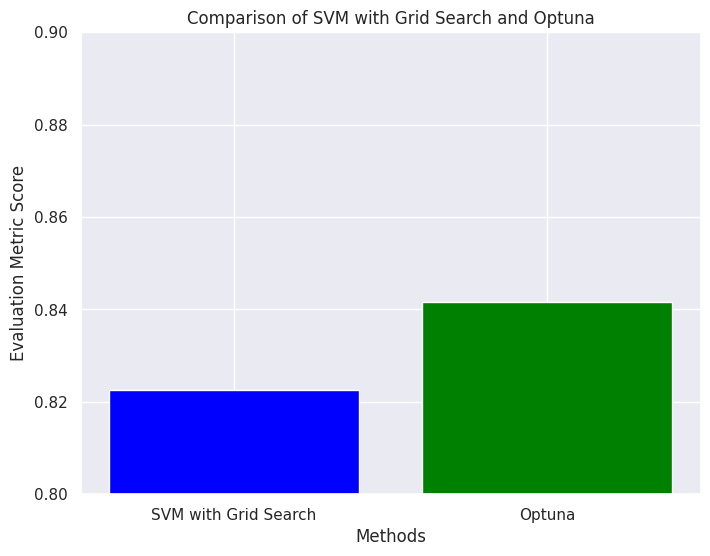

In [58]:
import matplotlib.pyplot as plt

# Evaluation metric scores obtained from the experiments
svm_grid_search_score = grid_search.best_score_  # Score from SVM with grid search
optuna_score = study.best_value  # Score from Optuna

# Define labels and scores
methods = ['SVM with Grid Search', 'Optuna']
scores = [svm_grid_search_score, optuna_score]

# Create bar chart
plt.figure(figsize=(8, 6))
plt.bar(methods, scores, color=['blue', 'green'])
plt.xlabel('Methods')
plt.ylabel('Evaluation Metric Score')
plt.title('Comparison of SVM with Grid Search and Optuna')
plt.ylim(0.8, 0.9)  # Adjust ylim based on your actual score range
plt.show()
